In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from scipy import stats

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2023.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 76
Número de linhas: 3933955


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A


In [3]:
#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ENSINO             2594874
TP_LOCALIZACAO_ESC    2975449
NU_NOTA_CN            1241528
NU_NOTA_CH            1111312
NU_NOTA_LC            1111312
NU_NOTA_MT            1241528
NU_NOTA_REDACAO       1111312
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'Até 2 salários mínimos',
    'B': 'Até 2 salários mínimos',
    'C': 'Até 2 salários mínimos',
    'D': 'Até 2 salários mínimos',
    'E': 'De 2 a 3 salários mínimos',
    'F': 'De 3 a 6 salários mínimos',
    'G': 'De 3 a 6 salários mínimos',
    'H': 'De 3 a 6 salários mínimos',
    'I': 'De 3 a 6 salários mínimos',
    'J': 'De 3 a 6 salários mínimos',
    'K': 'De 6 a 10 salários mínimos',
    'L': 'De 6 a 10 salários mínimos',
    'M': 'De 6 a 10 salários mínimos',
    'N': 'De 6 a 10 salários mínimos',
    'O': 'De 10 a 15 salários mínimos',
    'P': 'De 10 a 15 salários mínimos',
    'Q': 'Acima de 15 salários mínimos'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 3933955


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,14,M,2,1,1,1,17,1,1.0,1.0,...,D,C,B,B,D,C,C,B,B,De 3 a 6 salários mínimos
1,12,M,2,1,0,1,16,1,1.0,1.0,...,A,B,B,B,A,B,A,B,B,De 3 a 6 salários mínimos
2,6,F,1,1,1,1,0,1,1.0,1.0,...,A,B,A,B,A,B,A,A,B,Até 2 salários mínimos
3,2,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,Até 2 salários mínimos
4,3,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,Até 2 salários mínimos


In [8]:
# 1. Separar X e y
X = dataset_sem_nulos.drop(columns=['classe_social'])
y = dataset_sem_nulos['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('classificador', clf) 
])



# 6. Treinar modelo
modelo.fit(X, y)

# 7. Avaliar
y_pred = modelo.predict(X)
print("Acurácia:", accuracy_score(y, y_pred))
print("\nRelatório de classificação:\n", classification_report(y, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))


Acurácia: 0.9759232121363869

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     51489
      Até 2 salários mínimos       0.97      1.00      0.98   2601632
 De 10 a 15 salários mínimos       0.99      0.99      0.99     79323
   De 2 a 3 salários mínimos       0.98      0.87      0.93    293994
   De 3 a 6 salários mínimos       0.98      0.94      0.96    733099
  De 6 a 10 salários mínimos       1.00      0.97      0.98    174418

                    accuracy                           0.98   3933955
                   macro avg       0.99      0.96      0.97   3933955
                weighted avg       0.98      0.98      0.98   3933955


Matriz de confusão:
 [[  51299      68      13       5      88      16]
 [     62 2595135       8     982    5397      48]
 [    156     529   78215      25     353      45]
 [     26   34264      81  256664    2931      28]
 [    171   

In [9]:
def analisar_importancia_features_agregada(modelo, clf, categoricas, top_n=None):
    """
    Exibe a importância das features de um modelo DecisionTreeClassifier,
    somando as importâncias das dummies das features categóricas.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - categoricas: lista de colunas categóricas originais
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_agregado: DataFrame com importância agregada por feature
    """

    # Extrair nomes das features pós-transformação
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
    
    # Importâncias
    importances = clf.feature_importances_
    
    # Criar DataFrame
    df = pd.DataFrame({
        'feature_expandida': nomes_features,
        'importancia': importances
    })
    
    # Inicializar coluna de feature original
    df['feature_original'] = df['feature_expandida']
    
    # Mapear dummies categóricas para a feature original
    for cat in categoricas:
        mask = df['feature_expandida'].str.contains(f"__{cat}_")
        df.loc[mask, 'feature_original'] = cat
    
    # Agregar importâncias por feature original
    df_agregado = df.groupby('feature_original')['importancia'].sum().sort_values(ascending=False)
    
    # Filtrar top_n se necessário
    if top_n:
        df_agregado = df_agregado.head(top_n)
    
    # Print em texto
    print("Importância das features (agregada):")
    for feat, imp in df_agregado.items():
        print(f"Feature {feat}: {imp:.4f}")
    
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.bar(range(len(df_agregado)), df_agregado.values, align="center")
    plt.xticks(range(len(df_agregado)), df_agregado.index, rotation=90)
    plt.title("Importância das Features (DecisionTreeClassifier)")
    plt.tight_layout()
    plt.show()
    
    return df_agregado

In [19]:
def analisar_importancia_features(modelo, clf, top_n=None):
    """
    Exibe a importância individual das features (sem agregação) 
    de um modelo DecisionTreeClassifier treinado dentro de um pipeline.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_importancias: DataFrame com importâncias individuais
    """

    # Extrair nomes das features após o pré-processamento
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()

    # Pegar as importâncias
    importances = clf.feature_importances_

    # Criar DataFrame
    df_importancias = pd.DataFrame({
        'feature': nomes_features,
        'importancia': importances
    }).sort_values(by='importancia', ascending=False)

    # Filtrar top_n se solicitado
    if top_n:
        df_importancias = df_importancias.head(top_n)

    # Print simples
    print("Importância das features (sem agregação):")
    for feat, imp in zip(df_importancias['feature'], df_importancias['importancia']):
        print(f"{feat}: {imp:.4f}")

    # Gráfico
    plt.figure(figsize=(10,6))
    plt.barh(df_importancias['feature'], df_importancias['importancia'])
    plt.xlabel("Importância")
    plt.ylabel("Feature")
    plt.title("Importância Individual das Features (DecisionTreeClassifier)")
    plt.gca().invert_yaxis()  # deixa a mais importante no topo
    plt.tight_layout()
    plt.show()

    return df_importancias

In [10]:
def analisar_desempenho_por_classe(dataset, notas=['NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO'], salvar_fig=False, nome_fig_prefixo="desempenho"):
    """
    Analisa estatísticas das notas por classe social, incluindo média, mediana, moda,
    desvio padrão, variância, amplitude e coeficiente de variação.
    """

    # Criar coluna de média das notas
    dataset['media_notas'] = dataset[notas].mean(axis=1)

    # Funções auxiliares
    def calc_amplitude(x):
        return x.max() - x.min()
    
    def calc_cv(x):
        return (x.std() / x.mean()) * 100 if x.mean() != 0 else np.nan

    # Agrupar por classe social
    resumo = dataset.groupby('classe_social')['media_notas'].agg(
        media='mean',
        mediana='median',
        desvio_padrao='std',
        variancia='var',
        amplitude=calc_amplitude,
        coef_var=calc_cv
    ).reset_index()

    # Imprimir tabela
    print("\nResumo estatístico completo por classe social:")
    print(resumo)

    # Gráfico: média ± desvio padrão
    plt.figure(figsize=(20,6))
    plt.bar(resumo['classe_social'], resumo['media'], yerr=resumo['desvio_padrao'], capsize=5, color='skyblue')
    plt.xlabel("Classe Social")
    plt.ylabel("Média das notas")
    plt.title("Média e Desvio Padrão das Notas por Classe Social")
    plt.show()

    return resumo

Importância das features (agregada):
Feature Q010: 0.1866
Feature num__NU_NOTA_MT: 0.1005
Feature num__NU_NOTA_LC: 0.0898
Feature num__NU_NOTA_CH: 0.0891
Feature num__NU_NOTA_CN: 0.0862
Feature num__NU_NOTA_REDACAO: 0.0607
Feature Q008: 0.0543
Feature num__TP_FAIXA_ETARIA: 0.0420
Feature Q018: 0.0279
Feature num__TP_COR_RACA: 0.0255
Feature num__TP_ANO_CONCLUIU: 0.0253
Feature Q009: 0.0234
Feature Q011: 0.0219
Feature Q013: 0.0204
Feature Q019: 0.0203
Feature Q007: 0.0201
Feature Q014: 0.0166
Feature TP_SEXO: 0.0155
Feature num__TP_ESTADO_CIVIL: 0.0130
Feature Q015: 0.0129


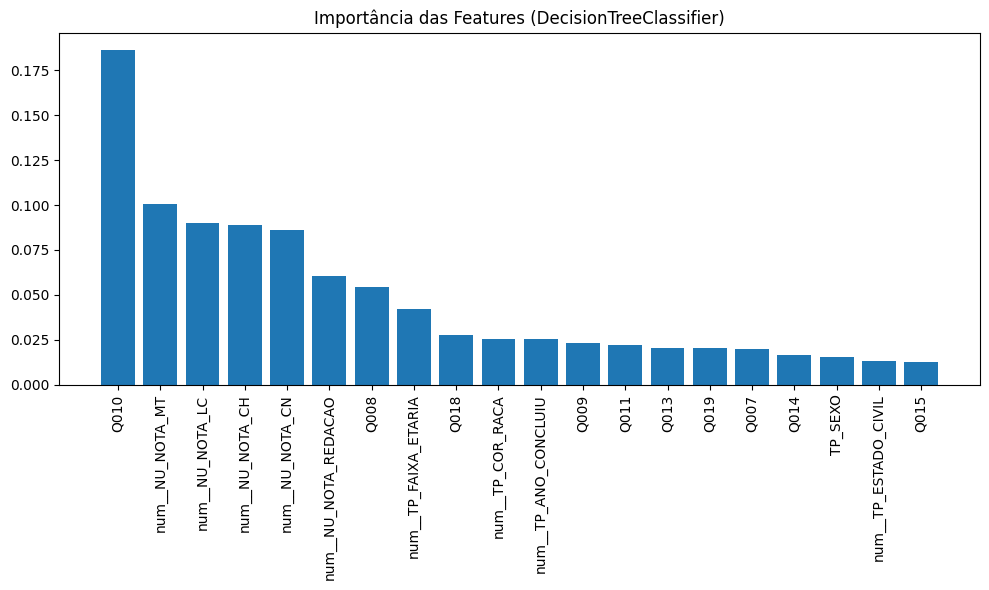

In [ ]:
df_importancia = analisar_importancia_features_agregada(modelo, clf, categoricas, 20)


Importância das features (sem agregação):
cat__Q010_A: 0.1786
num__NU_NOTA_MT: 0.1005
num__NU_NOTA_LC: 0.0898
num__NU_NOTA_CH: 0.0891
num__NU_NOTA_CN: 0.0862
num__NU_NOTA_REDACAO: 0.0607
cat__Q008_B: 0.0454
num__TP_FAIXA_ETARIA: 0.0420
num__TP_COR_RACA: 0.0255
num__TP_ANO_CONCLUIU: 0.0253
cat__Q018_A: 0.0165
cat__Q007_A: 0.0159
num__TP_ESTADO_CIVIL: 0.0130
cat__Q014_A: 0.0129
cat__Q018_B: 0.0114


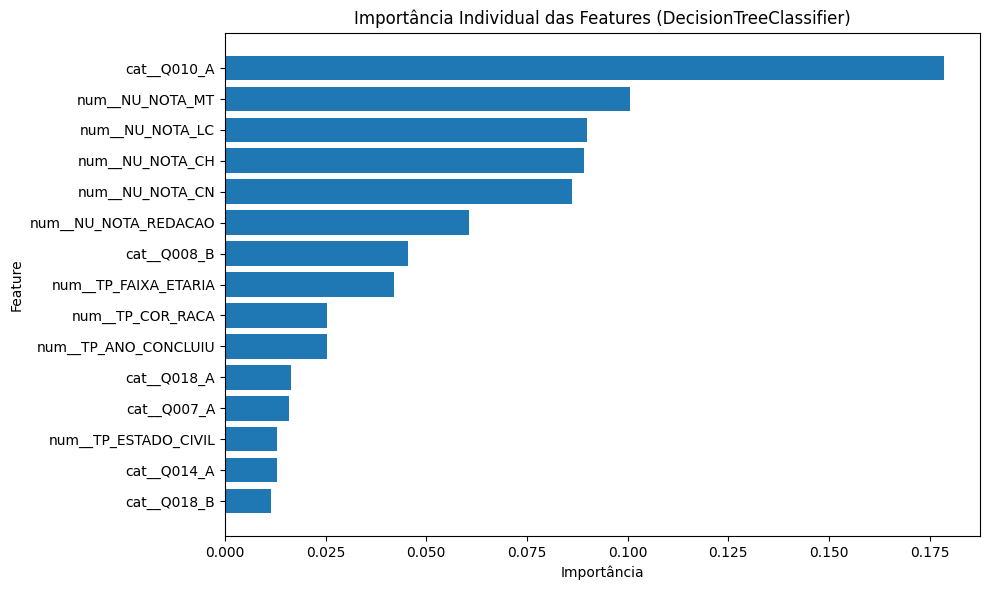

In [20]:
df_importancias_individuais = analisar_importancia_features(modelo, clf, top_n=15)



Resumo estatístico completo por classe social:
                  classe_social       media     mediana  desvio_padrao  \
0  Acima de 15 salários mínimos  624.727161  631.860000      87.895092   
1        Até 2 salários mínimos  518.209141  537.777315      71.151907   
2   De 10 a 15 salários mínimos  619.950986  624.880000      85.593298   
3     De 2 a 3 salários mínimos  547.516598  537.777315      74.421623   
4     De 3 a 6 salários mínimos  572.332019  557.360000      81.027562   
5    De 6 a 10 salários mínimos  604.964499  605.418725      85.049628   

     variancia  amplitude   coef_var  
0  7725.547248     792.52  14.069357  
1  5062.593873     847.54  13.730346  
2  7326.212653     736.80  13.806462  
3  5538.578001     836.80  13.592578  
4  6565.465800     862.58  14.157440  
5  7233.439202     847.26  14.058615  


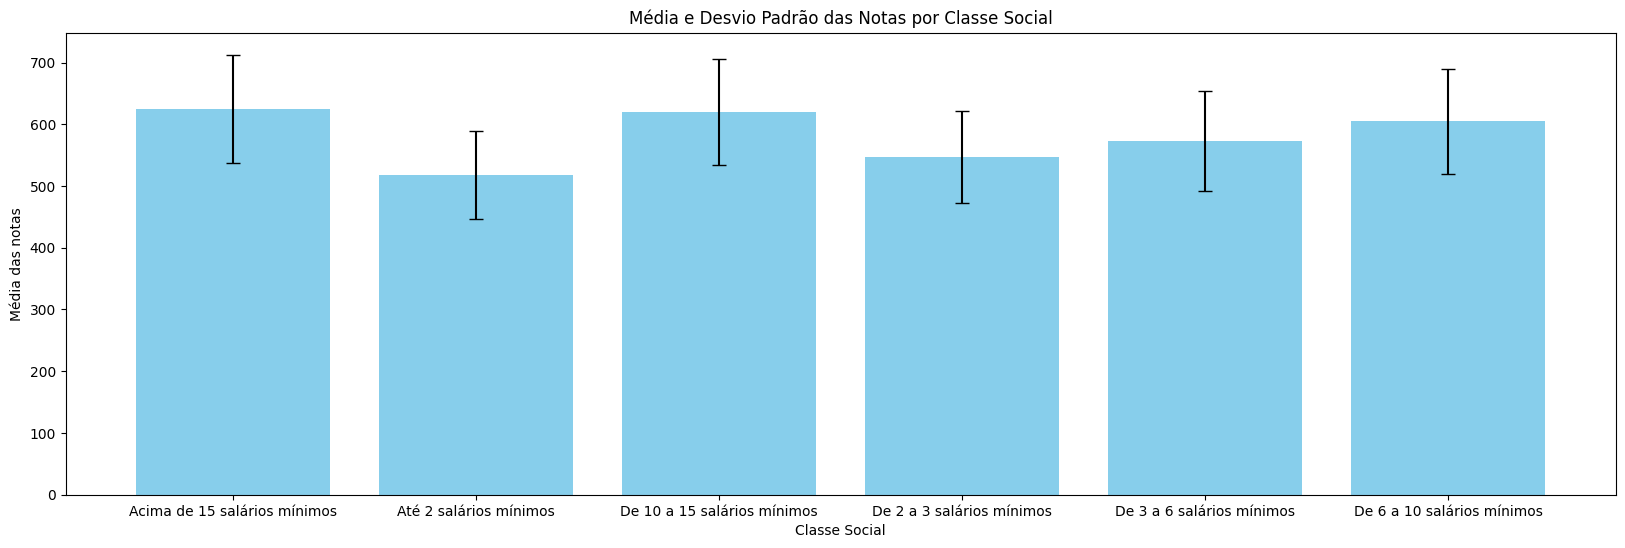

,classe_social,media,mediana,desvio_padrao,variancia,amplitude,coef_var
0,Acima de 15 salários mínimos,624.727161,631.860000,87.895092,7725.547248,792.52,14.069357
1,Até 2 salários mínimos,518.209141,537.777315,71.151907,5062.593873,847.54,13.730346
2,De 10 a 15 salários mínimos,619.950986,624.880000,85.593298,7326.212653,736.80,13.806462
3,De 2 a 3 salários mínimos,547.516598,537.777315,74.421623,5538.578001,836.80,13.592578
4,De 3 a 6 salários mínimos,572.332019,557.360000,81.027562,6565.465800,862.58,14.157440
5,De 6 a 10 salários mínimos,604.964499,605.418725,85.049628,7233.439202,847.26,14.058615


In [14]:
analisar_desempenho_por_classe(dataset_sem_nulos)

In [15]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]

In [16]:
# 1. Separar X e y
X_urbano = dataset_urbano.drop(columns=['classe_social'])
y_urbano = dataset_urbano['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_urbano = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_urbano = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_urbano = Pipeline(steps=[
    ('preprocessador', preprocessador_urbano),
    ('classificador', clf_urbano) 
])



# 6. Treinar modelo
modelo_urbano.fit(X_urbano, y_urbano)

# 7. Avaliar
y_pred_urbano = modelo_urbano.predict(X_urbano)
print("Acurácia:", accuracy_score(y_urbano, y_pred_urbano))
print("\nRelatório de classificação:\n", classification_report(y_urbano, y_pred_urbano))
print("\nMatriz de confusão:\n", confusion_matrix(y_urbano, y_pred_urbano))


Acurácia: 0.9757440733857408

Relatório de classificação:
                               precision    recall  f1-score   support

Acima de 15 salários mínimos       0.99      1.00      0.99     51421
      Até 2 salários mínimos       0.97      1.00      0.98   2572953
 De 10 a 15 salários mínimos       0.99      0.99      0.99     79174
   De 2 a 3 salários mínimos       0.98      0.87      0.92    291943
   De 3 a 6 salários mínimos       0.98      0.94      0.96    728953
  De 6 a 10 salários mínimos       1.00      0.97      0.98    173861

                    accuracy                           0.98   3898305
                   macro avg       0.99      0.96      0.97   3898305
                weighted avg       0.98      0.98      0.98   3898305


Matriz de confusão:
 [[  51231      68      13       5      88      16]
 [     62 2566460       8     979    5396      48]
 [    156     528   78067      25     353      45]
 [     26   34191      81  254686    2931      28]
 [    171   

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14732\2283834234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
                  classe_social       media     mediana  desvio_padrao  \
0  Acima de 15 salários mínimos  624.830056  631.980000      87.856635   
1        Até 2 salários mínimos  518.383721  537.777315      71.046949   
2   De 10 a 15 salários mínimos  620.008815  624.920000      85.591235   
3     De 2 a 3 salários mínimos  547.609059  537.777315      74.391194   
4     De 3 a 6 salários mínimos  572.406316  557.400000      81.021302   
5    De 6 a 10 salários mínimos  605.017668  605.460000      85.060937   

     variancia  amplitude   coef_var  
0  7718.788346     792.52  14.060885  
1  5047.668953     847.54  13.705475  
2  7325.859558     736.80  13.804842  
3  5534.049726     836.80  13.584727  
4  6564.451392     862.58  14.154509  
5  7235.362978     847.26  14.059248  


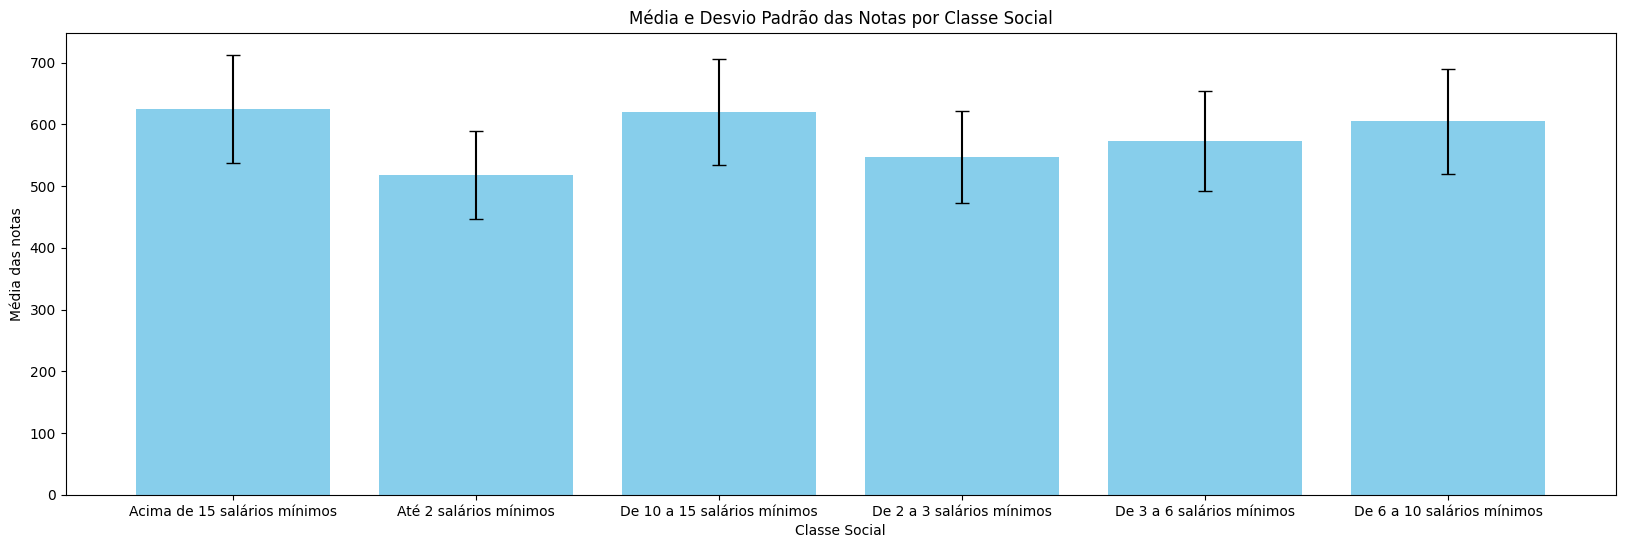

,classe_social,media,mediana,desvio_padrao,variancia,amplitude,coef_var
0,Acima de 15 salários mínimos,624.830056,631.980000,87.856635,7718.788346,792.52,14.060885
1,Até 2 salários mínimos,518.383721,537.777315,71.046949,5047.668953,847.54,13.705475
2,De 10 a 15 salários mínimos,620.008815,624.920000,85.591235,7325.859558,736.80,13.804842
3,De 2 a 3 salários mínimos,547.609059,537.777315,74.391194,5534.049726,836.80,13.584727
4,De 3 a 6 salários mínimos,572.406316,557.400000,81.021302,6564.451392,862.58,14.154509
5,De 6 a 10 salários mínimos,605.017668,605.460000,85.060937,7235.362978,847.26,14.059248


In [17]:
analisar_desempenho_por_classe(dataset_urbano)

Importância das features (agregada):
Feature Q010: 0.1866
Feature num__NU_NOTA_MT: 0.1010
Feature num__NU_NOTA_LC: 0.0898
Feature num__NU_NOTA_CH: 0.0892
Feature num__NU_NOTA_CN: 0.0863
Feature num__NU_NOTA_REDACAO: 0.0607
Feature Q008: 0.0542
Feature num__TP_FAIXA_ETARIA: 0.0422
Feature Q018: 0.0279
Feature num__TP_COR_RACA: 0.0255
Feature num__TP_ANO_CONCLUIU: 0.0253
Feature Q009: 0.0232
Feature Q011: 0.0217
Feature Q019: 0.0206
Feature Q013: 0.0203
Feature Q007: 0.0201
Feature Q014: 0.0166
Feature TP_SEXO: 0.0156
Feature Q015: 0.0131
Feature num__TP_ESTADO_CIVIL: 0.0130


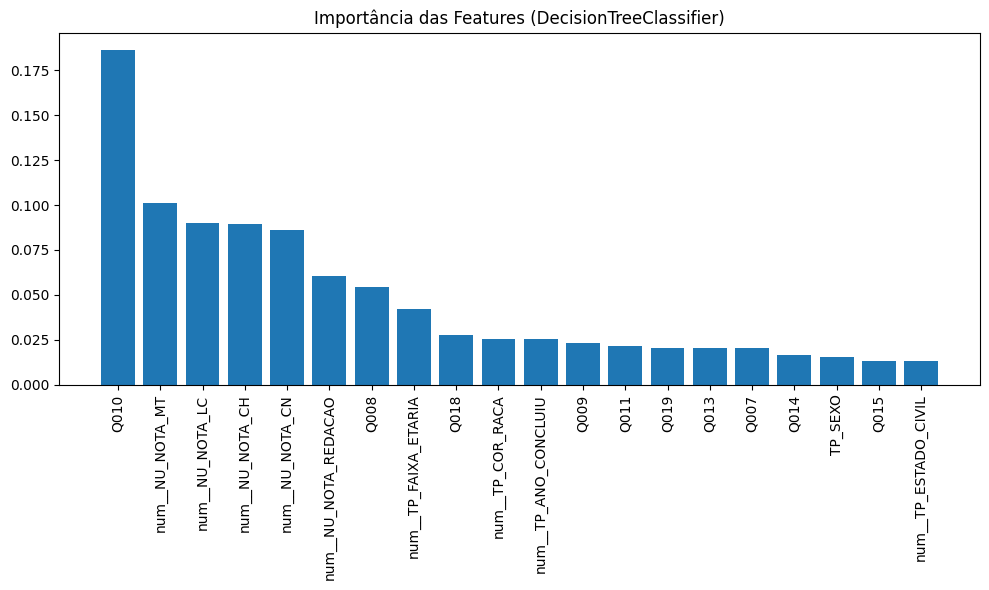

In [18]:
df_importancia_urbano = analisar_importancia_features_agregada(modelo_urbano, clf_urbano, categoricas, 20)

In [23]:
# 1. Separar X e y
X_rural = dataset_rural.drop(columns=['classe_social'])
y_rural = dataset_rural['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_rural = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_rural = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_rural = Pipeline(steps=[
    ('preprocessador', preprocessador_rural),
    ('classificador', clf_rural) 
])



# 6. Treinar modelo
modelo_rural.fit(X_rural, y_rural)

# 7. Avaliar
y_pred_rural = modelo_rural.predict(X_rural)
print("Acurácia:", accuracy_score(y_rural, y_pred_rural))
print("\nRelatório de classificação:\n", classification_report(y_rural, y_pred_rural))
print("\nMatriz de confusão:\n", confusion_matrix(y_rural, y_pred_rural))


Acurácia: 0.9920336605890603

Relatório de classificação:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        68
           B       1.00      1.00      1.00      1025
           C       0.99      0.98      0.98      8904
         D/E       0.99      0.99      0.99     25653

    accuracy                           0.99     35650
   macro avg       0.99      0.99      0.99     35650
weighted avg       0.99      0.99      0.99     35650


Matriz de confusão:
 [[   68     0     0     0]
 [    0  1023     0     2]
 [    0     2  8751   151]
 [    0     1   128 25524]]


C:\Users\Carlos\AppData\Local\Temp\ipykernel_6548\252894146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana  desvio_padrao    variancia  \
0             A  546.919173  537.777315      82.918582  6875.491272   
1             B  586.121025  588.080000      80.090489  6414.486389   
2             C  542.802090  537.777315      79.987805  6398.048928   
3           D/E  499.312258  537.777315      77.937957  6074.325089   

   amplitude   coef_var  
0  386.70255  15.161030  
1  574.72000  13.664497  
2  680.92000  14.736090  
3  621.90000  15.609061  


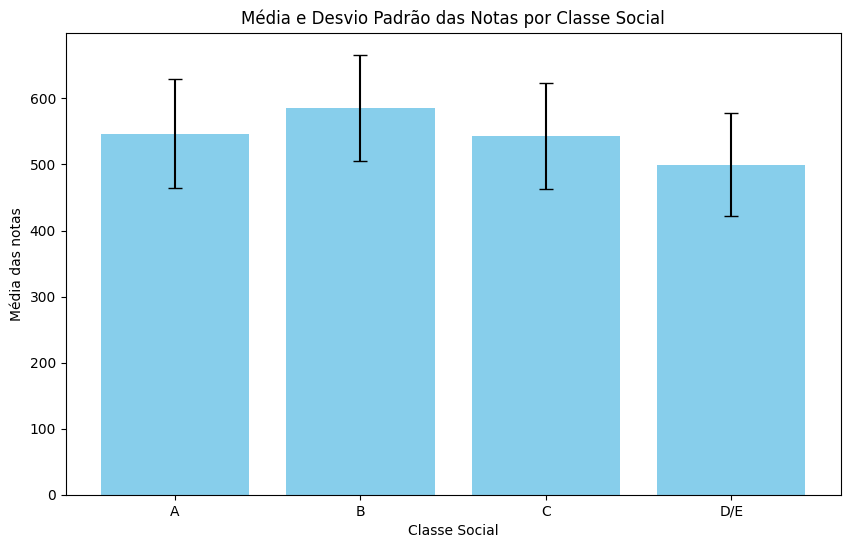

,classe_social,media,mediana,desvio_padrao,variancia,amplitude,coef_var
0,A,546.919173,537.777315,82.918582,6875.491272,386.70255,15.161030
1,B,586.121025,588.080000,80.090489,6414.486389,574.72000,13.664497
2,C,542.802090,537.777315,79.987805,6398.048928,680.92000,14.736090
3,D/E,499.312258,537.777315,77.937957,6074.325089,621.90000,15.609061


In [26]:
analisar_desempenho_por_classe(dataset_rural)

Importância das features (agregada):
Feature Q010: 0.2561
Feature num__NU_NOTA_MT: 0.0906
Feature num__NU_NOTA_CH: 0.0818
Feature num__NU_NOTA_LC: 0.0817
Feature num__NU_NOTA_CN: 0.0754
Feature num__NU_NOTA_REDACAO: 0.0598
Feature Q014: 0.0472
Feature num__TP_FAIXA_ETARIA: 0.0330
Feature Q008: 0.0315
Feature Q009: 0.0302
Feature Q011: 0.0298
Feature num__TP_COR_RACA: 0.0293
Feature Q019: 0.0235
Feature Q013: 0.0224
Feature TP_SEXO: 0.0207
Feature Q018: 0.0144
Feature Q015: 0.0139
Feature Q016: 0.0139
Feature Q007: 0.0110
Feature Q012: 0.0094


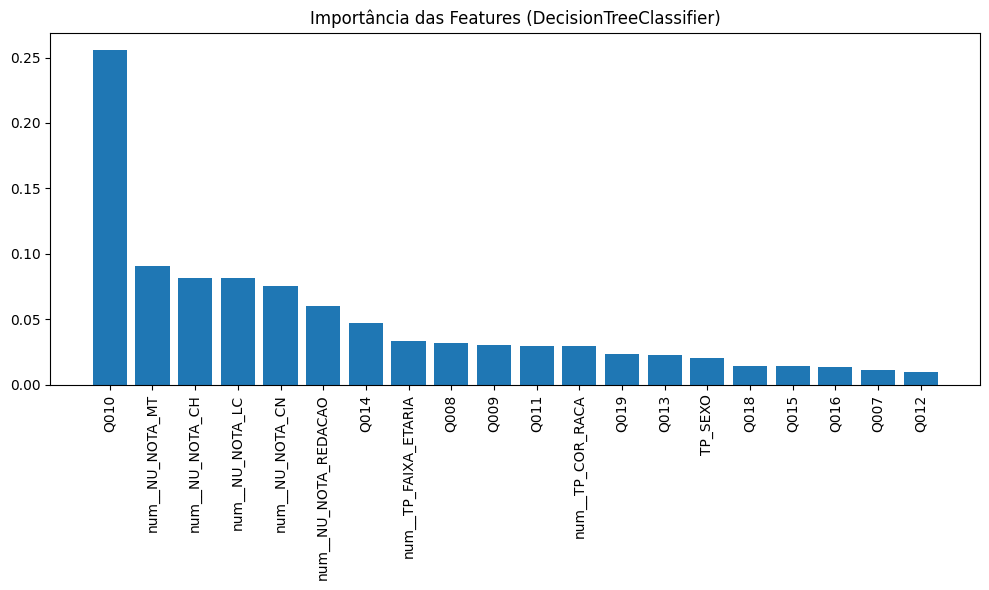

In [27]:
df_importancia_rural = analisar_importancia_features_agregada(modelo_rural,clf_rural, categoricas, top_n=20)

In [28]:
# Filtrar apenas homens
dataset_homem = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "M"]

# Filtrar apenas mulheres
dataset_mulher = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "F"]

In [29]:
# 1. Separar X e y
X_homem = dataset_homem.drop(columns=['classe_social'])
y_homem = dataset_homem['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_homem = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_homem = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_homem = Pipeline(steps=[
    ('preprocessador', preprocessador_homem),
    ('classificador', clf_homem) 
])



# 6. Treinar modelo
modelo_homem.fit(X_homem, y_homem)

# 7. Avaliar
y_pred_homem = modelo_homem.predict(X_homem)
print("Acurácia:", accuracy_score(y_homem, y_pred_homem))
print("\nRelatório de classificação:\n", classification_report(y_homem, y_pred_homem))
print("\nMatriz de confusão:\n", confusion_matrix(y_homem, y_pred_homem))

Acurácia: 0.965867465211424

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     26345
           B       0.98      0.98      0.98    153491
           C       0.96      0.95      0.96    592796
         D/E       0.97      0.97      0.97    750138

    accuracy                           0.97   1522770
   macro avg       0.98      0.98      0.98   1522770
weighted avg       0.97      0.97      0.97   1522770


Matriz de confusão:
 [[ 26233     31     55     26]
 [   148 150694   2140    509]
 [    84   1869 565199  25644]
 [    18    558  20894 728668]]


Importância das features (agregada):
Feature Q010: 0.1965
Feature num__NU_NOTA_MT: 0.0939
Feature num__NU_NOTA_LC: 0.0857
Feature num__NU_NOTA_CH: 0.0842
Feature num__NU_NOTA_CN: 0.0815
Feature num__NU_NOTA_REDACAO: 0.0572
Feature num__TP_FAIXA_ETARIA: 0.0461
Feature Q014: 0.0418
Feature Q008: 0.0392
Feature Q007: 0.0390
Feature num__TP_COR_RACA: 0.0282
Feature num__TP_ANO_CONCLUIU: 0.0280
Feature Q009: 0.0237
Feature Q019: 0.0210
Feature Q011: 0.0202
Feature Q013: 0.0186
Feature Q018: 0.0171
Feature num__TP_ESTADO_CIVIL: 0.0147
Feature Q016: 0.0144
Feature Q015: 0.0122


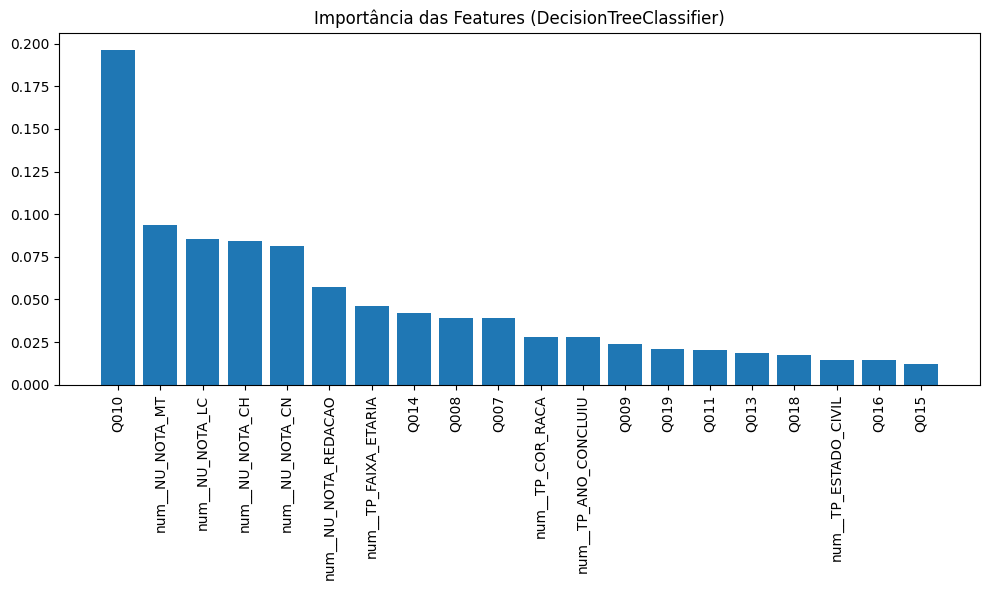

In [30]:
df_importancia_homem = analisar_importancia_features_agregada(modelo_homem, clf_homem, categoricas, 20)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_6548\252894146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana  desvio_padrao    variancia  \
0             A  622.174698  627.880000      91.539885  8379.550553   
1             B  601.007604  598.960000      87.925072  7730.818337   
2             C  552.363117  537.777315      79.203133  6273.136326   
3           D/E  515.591476  537.777315      74.482341  5547.619134   

   amplitude   coef_var  
0     785.22  14.712891  
1     847.26  14.629611  
2     862.58  14.338961  
3     840.26  14.445999  


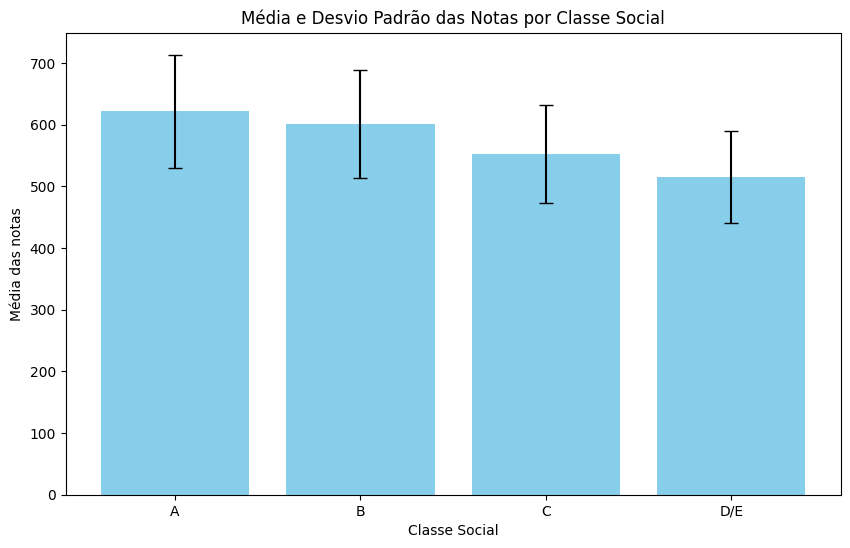

,classe_social,media,mediana,desvio_padrao,variancia,amplitude,coef_var
0,A,622.174698,627.880000,91.539885,8379.550553,785.22,14.712891
1,B,601.007604,598.960000,87.925072,7730.818337,847.26,14.629611
2,C,552.363117,537.777315,79.203133,6273.136326,862.58,14.338961
3,D/E,515.591476,537.777315,74.482341,5547.619134,840.26,14.445999


In [33]:
analisar_desempenho_por_classe(dataset_homem)

In [ ]:
# 1. Separar X e y
X_mulher = dataset_mulher.drop(columns=['classe_social'])
y_mulher = dataset_mulher['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_mulher = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_mulher = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_mulher = Pipeline(steps=[
    ('preprocessador', preprocessador_mulher),
    ('classificador', clf_mulher) 
])



# 6. Treinar modelo
modelo_mulher.fit(X_mulher, y_mulher)

# 7. Avaliar
y_pred_mulher = modelo_mulher.predict(X_mulher)
print("Acurácia:", accuracy_score(y_mulher, y_pred_mulher))
print("\nRelatório de classificação:\n", classification_report(y_mulher, y_pred_mulher))
print("\nMatriz de confusão:\n", confusion_matrix(y_mulher, y_pred_mulher))


Acurácia: 0.9678303406831081

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     25144
           B       0.99      0.98      0.98    175429
           C       0.96      0.94      0.95    796484
         D/E       0.97      0.98      0.97   1414128

    accuracy                           0.97   2411185
   macro avg       0.98      0.97      0.98   2411185
weighted avg       0.97      0.97      0.97   2411185


Matriz de confusão:
 [[  25038      32      53      21]
 [    158  172215    2448     608]
 [     80    1690  750010   44704]
 [     13     587   27173 1386355]]


C:\Users\Carlos\AppData\Local\Temp\ipykernel_6548\252894146.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana  desvio_padrao    variancia  \
0             A  627.401543  635.260000      83.825011  7026.632447   
1             B  610.553428  612.780000      82.788032  6853.858287   
2             C  556.767289  537.777315      76.653868  5875.815530   
3           D/E  513.678748  537.777315      68.222979  4654.374821   

   amplitude   coef_var  
0     682.00  13.360664  
1     786.00  13.559507  
2     844.46  13.767667  
3     826.30  13.281254  


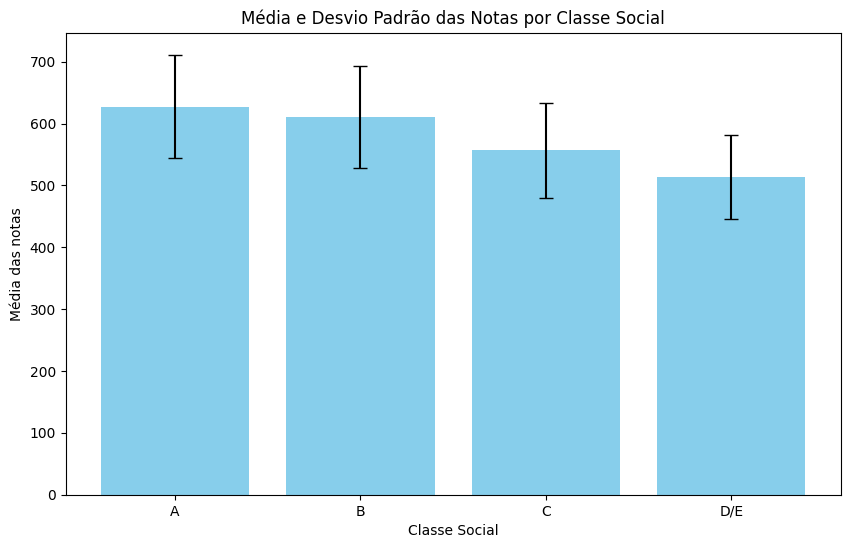

,classe_social,media,mediana,desvio_padrao,variancia,amplitude,coef_var
0,A,627.401543,635.260000,83.825011,7026.632447,682.00,13.360664
1,B,610.553428,612.780000,82.788032,6853.858287,786.00,13.559507
2,C,556.767289,537.777315,76.653868,5875.815530,844.46,13.767667
3,D/E,513.678748,537.777315,68.222979,4654.374821,826.30,13.281254


In [37]:
analisar_desempenho_por_classe(dataset_mulher)